<a href="https://colab.research.google.com/github/MaksymilianSzymczak/ML24/blob/main/domowe_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Analyzing and Plotting Bias in Penalized Regression**

-------------------------------

In this assignment, you will explore how **Ridge** and **Lasso** regression introduce **bias** into a model to reduce **variance**, and how the choice of the regularization parameter $\lambda$ affects this trade-off. The goal is to visualize and analyze the **bias-variance trade-off** and understand the conditions under which penalization helps or hinders model performance.

## **The Question**

**How does varying the regularization parameter $\lambda$ in Ridge and Lasso regression impact the trade-off between bias and variance?**

- Generate a synthetic dataset based on a **known** linear relationship:
  
  $$
  y = \beta_0 + \beta_1 x + \ldots + \epsilon
  $$

  where $$\epsilon \sim \mathcal{N}(0, \sigma^2),$$

  use a **high-dimensional** setting (e.g., 50 predictors) with only a few non-zero true coefficients to emphasize the effects of regularization. I stress, the $\beta_i$ coefficients should be known for this experiment and they should be mostly 0, with only a few non-zero parameters.

- Investigate how increasing $\lambda$ influences the model’s **bias**, **variance**, and **Mean Squared Error (MSE)**.
- Plot **Bias²**, **Variance**, and **MSE** on a single graph for both Ridge and Lasso models.
- Explain MSE decomposition into bias and variance. Read more on the MSE decomposition if you need to.

**Does the regularization lead to an optimal trade-off point where MSE is minimized? Explain why this point exists.**




**Expected Outcome:**
 - As $\lambda$ increases:
   - **Bias** increases (the model becomes too simple).
   - **Variance** decreases (the model becomes more stable).
   - **MSE** forms a **U-shape**, revealing the optimal trade-off.

- Analyze how **Ridge** and **Lasso** differ in terms of their bias-variance trade-offs.
- Discuss situations where one method may outperform the other, considering factors like **feature sparsity** and **multicollinearity**.


## **Colab Notebook Requirements**
- Your **Colab notebook** should:
  - Simulate the synthetic dataset and apply Ridge and Lasso regression.
  - Plot **Bias²**, **Variance**, and **MSE** against $\lambda$ for both models.
  - Include a section answering the questions.
  - Be well-documented with comments and explanations for each step.


## **Publish on GitHub**
- Upload your Colab notebook to your **GitHub repository** for this course.
- In your repository’s **README**, include a **link** to the notebook.
- In the notebook include **“Open in Colab”** badge so the notebook can be launched directly from GitHub.


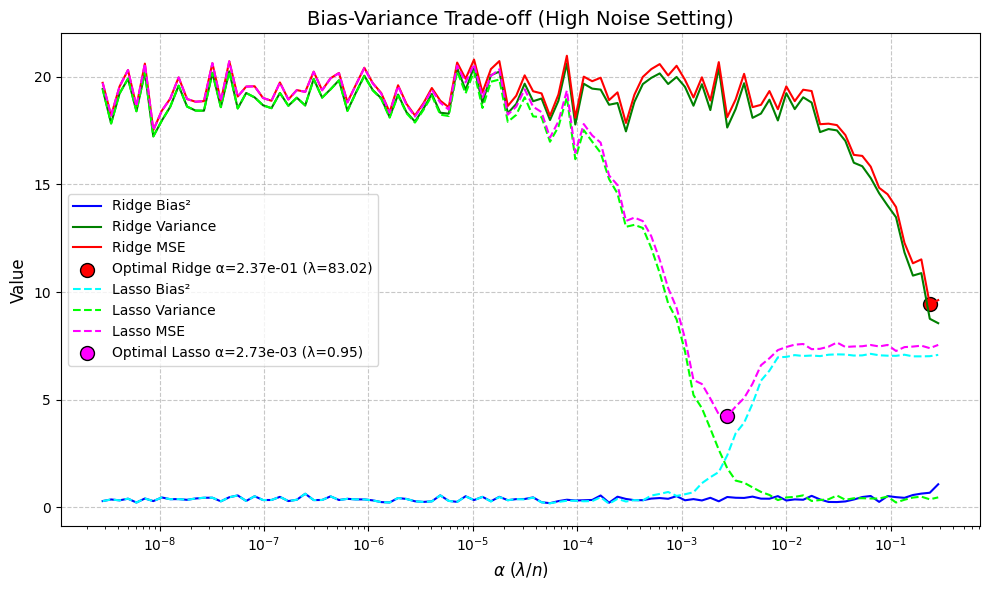

Ridge optimal α: 2.37e-01 (λ = 83.02)
Lasso optimal α: 2.73e-03 (λ = 0.95)


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset with high noise
n_samples = 350
n_features = 40
n_nonzero = 5  # Only 5 non-zero coefficients
sigma = 10.0    # High noise standard deviation

# True coefficients (sparse)
beta_true = np.zeros(n_features)
beta_true[:n_nonzero] = [2.0, -1.5, 1.0, -0.5, 0.3]

# Design matrix and response
X = np.random.randn(n_samples, n_features)
y = X @ beta_true + sigma * np.random.randn(n_samples)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Regularization parameters (α = λ/n)
alphas = np.logspace(-6, 2, 100) / n_samples

# Storage for metrics
metrics = {
    'Ridge': {'Bias²': [], 'Variance': [], 'MSE': []},
    'Lasso': {'Bias²': [], 'Variance': [], 'MSE': []}
}

# Monte Carlo simulation
n_simulations = 50
for alpha in alphas:
    ridge_preds = np.zeros((n_simulations, len(y_test)))
    lasso_preds = np.zeros((n_simulations, len(y_test)))

    for i in range(n_simulations):
        # Resample training data with noise
        y_train_noisy = X_train @ beta_true + sigma * np.random.randn(len(y_train))

        # Ridge regression
        ridge = Ridge(alpha=alpha * n_samples)
        ridge.fit(X_train, y_train_noisy)
        ridge_preds[i] = ridge.predict(X_test)

        # Lasso regression
        lasso = Lasso(alpha=alpha * n_samples, max_iter=10000)
        lasso.fit(X_train, y_train_noisy)
        lasso_preds[i] = lasso.predict(X_test)

    # Compute metrics
    for model, preds in [('Ridge', ridge_preds), ('Lasso', lasso_preds)]:
        mean_pred = np.mean(preds, axis=0)
        metrics[model]['Bias²'].append(np.mean((mean_pred - (X_test @ beta_true))**2))
        metrics[model]['Variance'].append(np.var(preds, axis=0).mean())
        metrics[model]['MSE'].append(metrics[model]['Bias²'][-1] + metrics[model]['Variance'][-1])

# Plot results
plt.figure(figsize=(10, 6))
colors = {'Ridge': ['blue', 'green', 'red'], 'Lasso': ['cyan', 'lime', 'magenta']}

for model in ['Ridge', 'Lasso']:
    linestyle = '-' if model == 'Ridge' else '--'
    plt.semilogx(alphas, metrics[model]['Bias²'],
                linestyle, color=colors[model][0], label=f'{model} Bias²')
    plt.semilogx(alphas, metrics[model]['Variance'],
                linestyle, color=colors[model][1], label=f'{model} Variance')
    plt.semilogx(alphas, metrics[model]['MSE'],
                linestyle, color=colors[model][2], label=f'{model} MSE')

    # Highlight optimal points
    opt_idx = np.argmin(metrics[model]['MSE'])
    plt.scatter(alphas[opt_idx], metrics[model]['MSE'][opt_idx],
                color=colors[model][2], s=100, edgecolor='black',
                label=f'Optimal {model} α={alphas[opt_idx]:.2e} (λ={alphas[opt_idx] * n_samples:.2f})')

plt.xlabel(r'$\alpha$ ($\lambda/n$)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Bias-Variance Trade-off (High Noise Setting)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print optimal α values
for model in ['Ridge', 'Lasso']:
    opt_idx = np.argmin(metrics[model]['MSE'])
    print(f"{model} optimal α: {alphas[opt_idx]:.2e} (λ = {alphas[opt_idx] * n_samples:.2f})")


Wzór dekompozycji MSE:
$$MSE = Bias^2 + Variance + IrreducibleErr$$

$Bias^2$ określa jak bardzo obciążone są wyniki estyapcji względem prawdziwych wartości. Variance określa wrażliwość modelu na zmiany danych. IrreducibleErr jest niezależny od poprzednich zmiennych i stanowi dolną granicę osiągalnego błędu estymacji (jest równy wariancji błędu losowego).

#1. How does varying the regularization parameter λ in Ridge and Lasso regression impact the trade-off between bias and variance?
Ridge: Wraz ze wzrostem λ, bias rośnie (model upraszcza się), a wariancja maleje (model staje się bardziej stabilny). Początkowo MSE maleje, ale przy zbyt dużych λ, MSE zaczyna rosnąć z powodu dominującego biasu.

Lasso: Podobnie jak w Ridge, wzrost λ prowadzi do wzrostu biasu i spadku wariancji. Lasso silniej dąży do redukcji liczby używanych cech, więc wariancja spada szybciej, a wpływ na bias może być bardziej wyraźny.

#2. Does the regularization lead to an optimal trade-off point where MSE is minimized? Explain why this point exists.

Tak, regularyzacja prowadzi do optymalnego punktu kompromisu, w którym MSE jest minimalizowane. Ten punkt istnieje, bo MSE można rozłożyć na bias², wariancję i szum, a wraz ze wzrostem λ, $bias^2$ rośnie, ale wariancja maleje. Na początku, spadek wariancji przeważa nad wzrostem $bias^2$, co obniża MSE. Jednak przy zbyt dużych wartościach λ, wzrost $bias^2$ zaczyna dominować, powodując wzrost MSE.
Optymalny punkt to wartość λ, gdzie suma $bias^2$ + variance + noise jest najmniejsza.

#3. Analyze how Ridge and Lasso differ in terms of their bias-variance trade-offs.

Ridge (Optymalne α: 2.37e-01, λ = 83.02): Ridge nie zeruje współczynników, tylko je zmniejsza. Z wykresu wynika, że $bias^2$ rośnie stosunkowo wolno, a wariancja maleje stopniowo wraz ze wzrostem λ. Optymalna wartość λ jest stosunkowo duża, co sugeruje, że model potrzebuje silnej regularyzacji, aby zredukować wariancję bez nadmiernego zwiększania biasu.

Lasso (Optymalne α: 2.73e-03, λ = 0.95): Lasso zeruje niektóre współczynniki. Na wykresie widać, że Lasso ma znacznie niższą optymalną wartość λ niż Ridge, co sugeruje, że nawet niewielka regularyzacja jest skuteczna w redukcji wariancji. Po przekroczeniu tej wartości, $bias^2$ zaczyna szybko rosnąć. W tym przypadku jest to dobre, bo tylko 5 współczynników jest niezerowych.

#4. Discuss situations where one method may outperform the other, considering factors like feature sparsity and multicollinearity.

Lasso:

Sparse data: Lasso jest preferowane, gdy tylko kilka cech ma istotny wpływ na wynik, a większość cech jest nieistotna. Generowany zbiór danych spełnia to założenie. Ta opcja zeruje nam mniej istotne współczynniki, co prowadzi do uproszczenia modelu, w którym tylko istotne cechy mają wpływ na wynik. (bardziej ekonomiczne)

Ridge:

Współliniowość: Ridge jest lepsze, gdy predyktory są silnie skorelowane. Zmniejsza współczynniki skorelowanych zmiennych bez ich eliminacji, co pozwala zachować ich wkład w model. Preferujemy tę opcję gdy wszystkie predyktory mają pewien wpływ na wynik i nie ma potrzeby ich eliminacji.